In [1]:
import torch

from config import *
from game import *

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(HEIGHT * WIDTH, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 1)

    def forward(self, game):
        x = game.convertToTensor() - 0.5
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [3]:
gamma = 0.99
learningRate = 0.01

framesPerUpdateTarget = 1000
cntFrames = 0

network = Network()
target_network = Network()
target_network.load_state_dict(network.state_dict())
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learningRate)

optimizer.zero_grad()

In [4]:
def getAvailablePlaces(g, figureID):
    availablePlaces = []
    for i in range(HEIGHT):
        for j in range(WIDTH):
            if g.canPlace(i, j, figureID):
                availablePlaces.append([i, j])
    return availablePlaces

In [5]:
def playGame(t_max=10_000, epsilon=0.1):
    global cntFrames
    g = Game()
    g.reset()
    
    totalReward = 0
    
    for _ in range(t_max):
        nextFigureID = g.generateNextFigure()
        availablePlaces = getAvailablePlaces(g, nextFigureID)
        
        if len(availablePlaces) == 0:
            # done
            # print(_)
            break
        
        if np.random.random() < epsilon:
            # make random action
            place = availablePlaces[np.random.randint(len(availablePlaces))]
            
            flag, reward, nextState = makeStep(g, nextFigureID, place[0], place[1])
            totalReward += reward
            
            nextScore = target_network(nextState).detach() * gamma + reward
            optimizer.zero_grad()
            loss = criterion(network(g), nextScore)
            loss.backward()
            optimizer.step()
            
            g = nextState
        else:
            bestScore = None
            bestState = None
            for place in availablePlaces:
                flag, reward, nextState = makeStep(g, nextFigureID, place[0], place[1])
                nextScore = target_network(nextState).detach() * gamma + reward
                
                if bestScore is None or nextScore > bestScore:
                    bestScore = nextScore
                    bestState = nextState
        
            optimizer.zero_grad()
            loss = criterion(network(g), bestScore)
            loss.backward()
            optimizer.step()
            
            g = bestState
        
        cntFrames += 1
        
        if cntFrames % framesPerUpdateTarget == 0:
            target_network.load_state_dict(network.state_dict())
            
        
    return totalReward

In [6]:
epsilon = 0.9

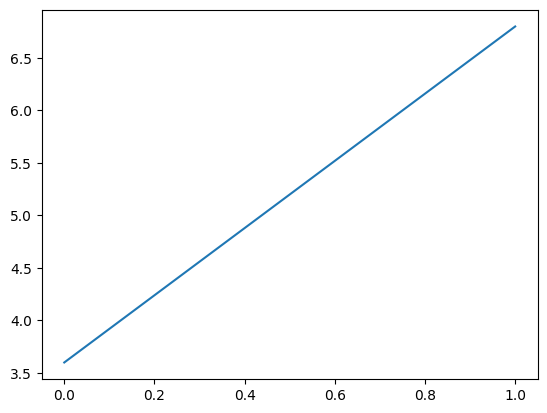

In [ ]:
from IPython.display import clear_output

x = []
y = []

for i in range(2000):
    session_rewards = [playGame(t_max=10000, epsilon=epsilon) for _ in range(20)]
    
    clear_output(True)
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), epsilon))
    
    epsilon = max(epsilon * 0.99, 0.1)
    
    x.append(i)
    y.append(np.mean(session_rewards))

    plt.plot(x, y)
    plt.show()